- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)
- Code: [ndb's Batch Normalization](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Batch_Normalization_Evaluation_(with_Residual_Connection).ipynb)

Batch Normalization의 효과를 관찰하고자 당시 각광받던 ResNet을 이용하였다. 그리고 결과만 확인할 용도로 적당히 작게 만드신 듯하다.

In [1]:
import os

# about data
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor

# model
import torch
from torch import optim
import torch.nn.functional as F
from torch.backends import cudnn
from torch.nn import Sequential, Module, Conv2d, BatchNorm2d, Linear, CrossEntropyLoss

# visualization
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)

1.9.1+cu111


### simple block부터 resnet class 정의

In [3]:
class BasicBlock(Module):
    def __init__(self, in_planes, planes, with_BN, stride=1):
        super(BasicBlock, self).__init__()
        self.with_BN = with_BN

        # 1 layer, 3X3 size에 1 padding이니까 stride에 따라 다르지만, 일단 원본이랑 같은 크기
        self.conv1 = Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        if with_BN:
            self.bn1 = BatchNorm2d(planes)

        # 2 layer, 크기 유지
        self.conv2 = Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN:
            self.bn2 = BatchNorm2d(planes)

        self.shortcut = Sequential()
        if stride != 1: # stride가 1이 아니면 skip connection이 안 되지 않나? 그래서 identity mapping이 아닌 경우라고 한 건가?
            modules = [Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)]
            if with_BN:
                modules.append(BatchNorm2d(planes))
            self.shortcut = Sequential(*modules)

    def forward(self, x):
        if self.with_BN:
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
        else:
            out = F.relu(self.conv1(x))
            out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [4]:
class ResNet(Module):
    def __init__(self, block, num_block, with_BN, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.with_BN = with_BN

        self.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN:
            self.bn1 = BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, with_BN, num_block[0], stride=1)
        self.layer2 = self._make_layer(block, 128, with_BN, num_block[1], stride=2)
        self.layer3 = self._make_layer(block, 256, with_BN, num_block[2], stride=2)
        self.layer4 = self._make_layer(block, 512, with_BN, num_block[3], stride=2)
        self.linear = Linear(512, num_classes)

    def _make_layer(self, block, planes, with_BN, num_block, stride):
        strides = [stride] + [1] * (num_block - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, with_BN, stride))
            self.in_planes = planes
        return Sequential(*layers)

    def forward(self, x):
        if self.with_BN:
            out = F.relu(self.bn1(self.conv1(x)))
        else:
            out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), - 1) # flatten?
        out = self.linear(out)
        return out

In [5]:
def ResNet18(with_BN):
    return ResNet(BasicBlock, [2, 2, 2, 2], with_BN)

### CiFar10을 이용해보자?

In [6]:
transform_train = Compose([RandomCrop(32, padding=4), RandomHorizontalFlip(), ToTensor(),])
transform_test = Compose([ToTensor(), ])

In [7]:
train_datasets = CIFAR10(root="./data", train=True, download=False, transform=transform_train) # download=True
test_datasets = CIFAR10(root="./data", train=False, download=False, transform=transform_test) # download=True

In [8]:
train_loader = DataLoader(train_datasets, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_datasets, batch_size=100, shuffle=False, num_workers=4)

### 학습 정의

In [9]:
criterion = CrossEntropyLoss()

In [10]:
def train(net, optimizer, epoch, step):
    net.train()
    total, correct = 0, 0
    steps, losses = [], []

    for _, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

        steps.append(step)
        losses.append(loss.item())
        step += 1
    return correct / total, steps, losses

In [11]:
def test(net, optimizer, epoch):
    net.eval()
    correct, total, loss = 0, 0, 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0) # sum sample size
    return correct / total, loss

## with BN, without BN 비교

### without BN

In [12]:
learning_rate = 0.01

net = ResNet18(with_BN=False).cuda()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("trainable parameters: ", total_params)

trainable parameters:  11164362


In [13]:
without_steps = []
without_train_accuracies = []
without_train_losses = []

without_test_accuracies = []
without_test_losses = []

epochs = 20
for epoch in range(epochs):
    print(f"[ Epoch: {epoch} / {epochs}")

    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(without_steps))
    without_train_accuracies.append(train_accuracy)
    without_steps.extend(steps)
    without_train_losses.extend(train_losses)
    print(f"Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}")

    test_accuracy, test_loss = test(net, optimizer, epoch)
    without_test_accuracies.append(test_accuracy)
    without_test_losses.append(test_loss)
    print(f"Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}")

[ Epoch: 0 / 20
Train accuracy = 14.48 / Train loss = 867.5268923044205
Test accuracy = 22.59 / Test loss = 202.39108037948608
[ Epoch: 1 / 20
Train accuracy = 27.30 / Train loss = 767.653090596199
Test accuracy = 31.91 / Test loss = 181.9395912885666
[ Epoch: 2 / 20
Train accuracy = 34.22 / Train loss = 693.6105041503906
Test accuracy = 38.85 / Test loss = 164.50764989852905
[ Epoch: 3 / 20
Train accuracy = 39.85 / Train loss = 640.2582837343216
Test accuracy = 43.00 / Test loss = 154.3588466644287
[ Epoch: 4 / 20
Train accuracy = 43.70 / Train loss = 598.098522901535
Test accuracy = 47.72 / Test loss = 142.4495882987976
[ Epoch: 5 / 20
Train accuracy = 47.56 / Train loss = 561.4950242042542
Test accuracy = 51.08 / Test loss = 132.23502933979034
[ Epoch: 6 / 20
Train accuracy = 52.02 / Train loss = 519.058030962944
Test accuracy = 54.67 / Test loss = 127.89752566814423
[ Epoch: 7 / 20
Train accuracy = 56.47 / Train loss = 477.16156405210495
Test accuracy = 56.80 / Test loss = 119.2777

iteration이 반올림해서 8000, epoch도 반올림해서 20<br />
(epoch step마다 train, test를 한 번씩 불렀으니까 test에 대한 epoch은 train과 같다.)

1 epoch : len(train) / batch_size만큼 학습임을 감안했을 때<br />
iteration = epoch * (len(train) / batch_size)<br />
-> 8000 = 20 * len(train) / 128

따라서 train의 크기는 51200으로 추측할 수 있다.<br />
그런데 지금 쓰고자 하는 건 len(train) / batch_size이고, 이 값은 400이다.

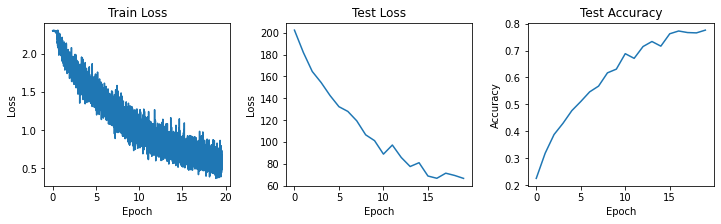

In [14]:
train_per_epoch = 400
f, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot([i / train_per_epoch for i in without_steps], without_train_losses)
ax[1].plot([i for i in range(len(without_test_losses))], without_test_losses)
ax[2].plot(np.arange(len(without_test_accuracies)), without_test_accuracies)

for i in range(len(ax)):
    ax[i].set_xlabel("Epoch")
    if i < 2:
        ax[i].set_ylabel("Loss")
    else:
        ax[i].set_ylabel("Accuracy")

ax[0].set_title("Train Loss")
ax[1].set_title("Test Loss")
ax[2].set_title("Test Accuracy")

plt.subplots_adjust(wspace=.3)
plt.show()

왜 Train loss랑 test loss를 한 번에 안 그렸는지 단박에 알겠네.<br />
validation처럼 train에 영향을 준 게 아니라서 그런지 loss의 분포 위치가 다르구나.

### with BN

In [15]:
# learning_rate = 0.01

net = ResNet18(with_BN=True).cuda()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("trainable parameters: ", total_params)

trainable parameters:  11173962


In [16]:
with_steps = []
with_train_accuracies = []
with_train_losses = []

with_test_accuracies = []
with_test_losses = []

epochs = 20
for epoch in range(epochs):
    print(f"[ Epoch: {epoch} / {epochs}")

    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(with_steps))
    with_train_accuracies.append(train_accuracy)
    with_steps.extend(steps)
    with_train_losses.extend(train_losses)
    print(f"Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}")

    test_accuracy, test_loss = test(net, optimizer, epoch)
    with_test_accuracies.append(test_accuracy)
    with_test_losses.append(test_loss)
    print(f"Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}")

[ Epoch: 0 / 20
Train accuracy = 47.41 / Train loss = 561.6723639965057
Test accuracy = 45.05 / Test loss = 172.07611680030823
[ Epoch: 1 / 20
Train accuracy = 67.08 / Train loss = 363.33552074432373
Test accuracy = 70.70 / Test loss = 84.36143988370895
[ Epoch: 2 / 20
Train accuracy = 74.62 / Train loss = 280.07264626026154
Test accuracy = 75.30 / Test loss = 73.86651957035065
[ Epoch: 3 / 20
Train accuracy = 79.17 / Train loss = 235.1066770851612
Test accuracy = 78.35 / Test loss = 63.41222482919693
[ Epoch: 4 / 20
Train accuracy = 81.74 / Train loss = 203.6258000433445
Test accuracy = 75.41 / Test loss = 73.6747952401638
[ Epoch: 5 / 20
Train accuracy = 83.59 / Train loss = 184.3923556804657
Test accuracy = 80.49 / Test loss = 57.55788692831993
[ Epoch: 6 / 20
Train accuracy = 85.63 / Train loss = 162.91549035906792
Test accuracy = 83.11 / Test loss = 52.27194072306156
[ Epoch: 7 / 20
Train accuracy = 86.59 / Train loss = 151.41146431863308
Test accuracy = 83.52 / Test loss = 49.864

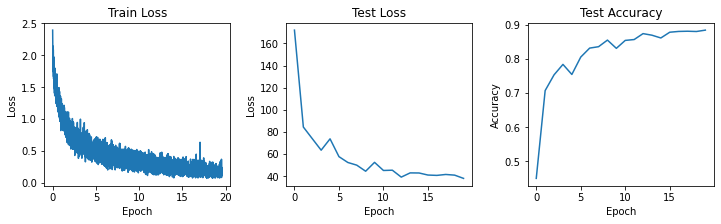

In [17]:
train_per_epoch = 400
f, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot([i / train_per_epoch for i in with_steps], with_train_losses)
ax[1].plot([i for i in range(len(with_test_losses))], with_test_losses)
ax[2].plot(np.arange(len(with_test_accuracies)), with_test_accuracies)

for i in range(len(ax)):
    ax[i].set_xlabel("Epoch")
    if i < 2:
        ax[i].set_ylabel("Loss")
    else:
        ax[i].set_ylabel("Accuracy")

ax[0].set_title("Train Loss")
ax[1].set_title("Test Loss")
ax[2].set_title("Test Accuracy")

plt.subplots_adjust(wspace=.3)
plt.show()

### compare in graph

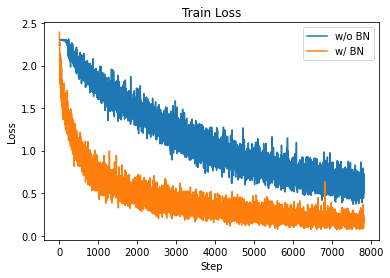

In [18]:
plt.plot(without_steps, without_train_losses, label="w/o BN")
plt.plot(with_steps, with_train_losses, label="w/ BN")

plt.legend(loc="best")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train Loss")

plt.show()

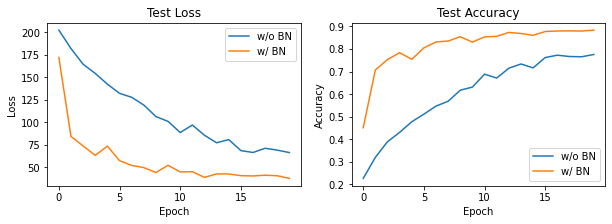

In [19]:
f, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(np.arange(len(without_test_losses)), without_test_losses, label="w/o BN")
ax[0].plot(np.arange(len(with_test_losses)), with_test_losses, label="w/ BN")

ax[1].plot(np.arange(len(without_test_accuracies)), without_test_accuracies, label="w/o BN")
ax[1].plot(np.arange(len(with_test_accuracies)), with_test_accuracies, label="w/ BN")

for i in range(len(ax)):
    ax[i].legend(loc="best")
    ax[i].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")

ax[0].set_title("Test Loss")
ax[1].set_title("Test Accuracy")

plt.show()

Batch Normalization이 있을 때 더 빠르게 학습하고, 더 낮은 loss를 보인다. Test 정확도도 높은데 Train의 noise라고 하긴 애매하지만, 그에 대한 과대적합을 피하고 보편적으로 학습하는데 도움이 되는 듯하다.